# MSDS 7331 - Case Study 4 - Financial Bankruptcy Classification
Daniel Crouthamel

Sophia Wu

Fabio Savorgnan

Bo Yun

# Introduction

In this study, we will be building a classifier to predict businesses that will go into bankruptcy.

# Business Understanding

Business forecasting refers to the tools and techniques used to predict developments in business, such as sales, expenditures, and profits. The purpose of business forecasting is to develop better strategies based on these informed predictions. Past data is collected and analyzed via quantitative or qualitative models so that patterns can be identified and can direct demand planning, financial operations, future production, and marketing operations. 

Therefore, we use business forecasting principles to predict business that could go on bankruptcy. We will use the data given to us and perform the following process:

Data Engineering:
Model Preparation:
Model Building & Evaluation:
Model Interpretability & Expandability:
Conclusion:

In [40]:
#importing libraries and reading in file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy.stats import randint as sp_randint

#general sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

# Yellowbrick
from yellowbrick.model_selection import FeatureImportances

#Pipeline
from sklearn.pipeline import make_pipeline

# Files
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
from scipy.io import arff


# Data Engineering

This dataset contains financial information from different business. The rows are the business 43405, and the columns are the variables with information from the different business. With the objective to include most of the available data. We decided that missing values less than 10 % we would keep as variables for our mode, because we would impute with the mean for each column to replace the missing values. We will use the simple imputer. Some columns are skew but the mean and the medium are very close, therefore we decided to replace the missing values with the mean.

So we decided to take out the Attr 21  "Sales (n) / sales (n-1)" because it has 13.5 missing values, also we decide to take out Attr 37 "Profit on operating activities / financial expenses" because it has 43.7 missing values. We believe, especially for Attr 37, that this number of missing values would not be able to replace in a meaningful way with imputation.

We also plan to normalize the data using the robust scaler, we know that because the model that we are using, Random Forest and Gradient Boosting, the normalization will not affect the performance of the model that much.

The selected model, Gradient Boosting is an effective machine learning model, even on datasets where the class distribution is skewed. Before any modification or tuning is made to the Gradient Boosting algorithm for imbalanced classification, it is important to test the default Gradient Boosting model and establish a baseline in performance. So, our final selected model is Gradient Boosting, and we expect that our model will deal with the unbalanced data given to us in the used dataset. But we will keep in mind the unbalanced data target in the preparation, building and evaluation of our model.

Please see the attached pandas profiles and code describing the process that we just described.


## Load the data and EDA

In [2]:
files = ['data/1year.arff', 'data/2year.arff', 'data/3year.arff', 'data/4year.arff', 'data/5year.arff']


df = pd.DataFrame(arff.loadarff(files[0])[0])

for f in files[1:]:
    data_temp = arff.loadarff(f)
    df_temp = pd.DataFrame(data_temp[0])
    print(df_temp.shape)
    df = df.merge(df_temp,how='outer') 

(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [4]:
print(df.shape)
df.head()

(43405, 65)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [5]:
df.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,43397.000000,43397.000000,43397.000000,43271.000000,4.331600e+04,43397.000000,43397.000000,43311.000000,43396.000000,43397.000000,...,4.340400e+04,4.327800e+04,43398.000000,4.332100e+04,43398.000000,4.125300e+04,43303.000000,4.327800e+04,43271.000000,42593.000000
mean,0.035160,0.590212,0.114431,6.314702,-3.853466e+02,-0.056107,0.093478,12.640779,2.652166,0.626868,...,7.672188e+03,-2.621959e+01,-0.010510,3.002644e+01,1.333288,4.480858e+02,17.033202,1.502328e+03,9.343074,72.788592
std,2.994109,5.842748,5.439429,295.434425,6.124303e+04,7.201326,5.713075,505.894281,62.932732,14.670597,...,7.005310e+04,5.327862e+03,13.674072,5.334454e+03,122.104445,3.234560e+04,553.049406,1.392667e+05,124.177354,2369.339482
min,-463.890000,-430.870000,-479.960000,-0.403110,-1.190300e+07,-508.410000,-517.480000,-141.410000,-3.496000,-479.910000,...,-1.805200e+06,-1.108300e+06,-1667.300000,-1.986900e+02,-327.970000,-1.244000e+01,-12.656000,-2.336500e+06,-1.543200,-10677.000000
25%,0.003429,0.268980,0.021521,1.049500,-4.908000e+01,0.000000,0.005776,0.430275,1.018500,0.295470,...,2.755425e+01,9.348500e-03,0.014649,8.753200e-01,0.000000,5.545500e+00,4.510150,4.214400e+01,3.097650,2.176800
50%,0.049660,0.471900,0.196610,1.569800,-1.034500e+00,0.000000,0.059634,1.070400,1.195350,0.505970,...,1.088350e+03,5.294300e-02,0.119670,9.509600e-01,0.006366,9.791700e+00,6.636300,7.132600e+01,5.087600,4.282500
75%,0.129580,0.688320,0.403390,2.787450,5.063425e+01,0.089446,0.150880,2.615700,2.062500,0.709100,...,4.993325e+03,1.290975e-01,0.284605,9.926400e-01,0.236052,2.018100e+01,10.394500,1.172200e+02,8.598850,9.776200
max,94.280000,480.960000,28.336000,53433.000000,1.250100e+06,543.250000,649.230000,53432.000000,9742.300000,1099.500000,...,6.123700e+06,2.931500e+02,552.640000,1.108300e+06,23853.000000,4.818700e+06,108000.000000,2.501600e+07,23454.000000,294770.000000


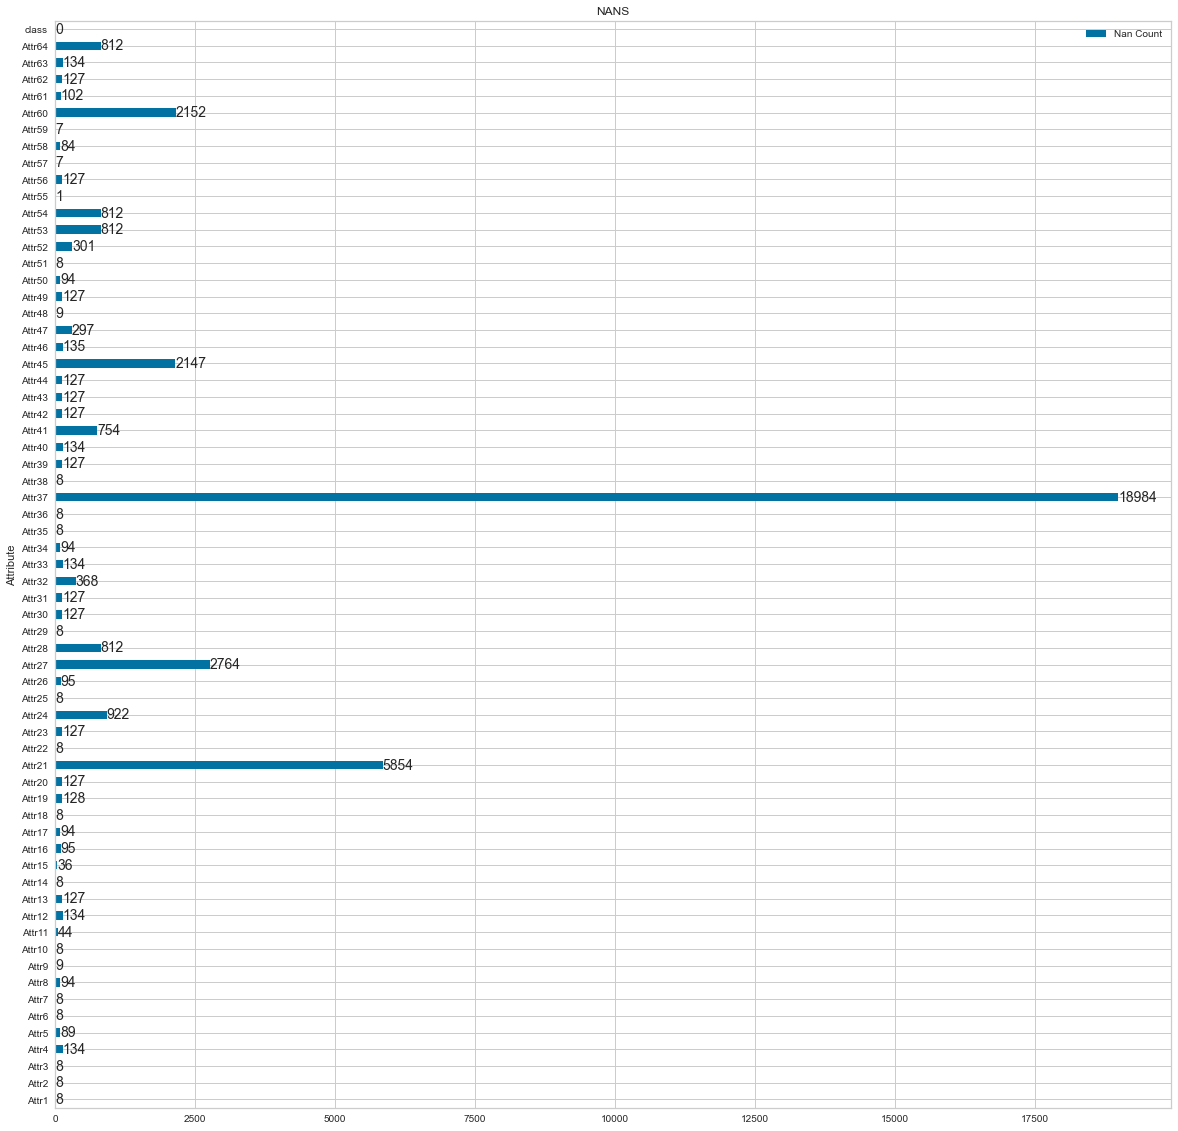

In [6]:
# Checking missing values 
nan_columns = []
nan_values = []

for column in df.columns:
    nan_columns.append(column)
    nan_values.append(df[column].isnull().sum())
    
nan_dict = {'Attributes': nan_columns, "Nan Count": nan_values}

# *dc - specify index, so I can see the attribute on the left, not some index value
nan_df = pd.DataFrame(nan_dict, index=df.columns.to_list())

ax = nan_df.plot(kind='barh', stacked=True, figsize=(20, 20), rot=0, xlabel='Attribute', ylabel='Count', title = 'NANS')
for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize = 14)

Above we can see that we have a fair amount of attributes with missing values. We will impute missing values during the Model building phase.

We will however at this point drop 2 columns, Attr 21 and Attr 37 due to the large number of missing values.

In [7]:
df= df.drop(["Attr21"], axis = 1)
df= df.drop(["Attr37"], axis = 1)

In [ ]:
# *dc - Comment out, we are imputing later so I'm not sure why this was added here.

# # Now fill all missing values with the mean of the column 
# df = df.where(pd.notna(df), df.interpolate(), axis="columns")

# # After filling th missing values, check it again.
# missing = df.isnull().any(axis=1).sum()
# len_before = df.shape[0]
# print(f"Total records missing data: {missing}\n"
#       f"Total percent of incomplete records: {missing/len_before*100:.2f}%"
#      )

## Evaluate and Transform Response Variable

Upon inspection of the date it was observed the reponse was stored as a byte. We will convert it to a string.

In [8]:
df["class"].value_counts()

b'0'    41314
b'1'     2091
Name: class, dtype: int64

(array([41314.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2091.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

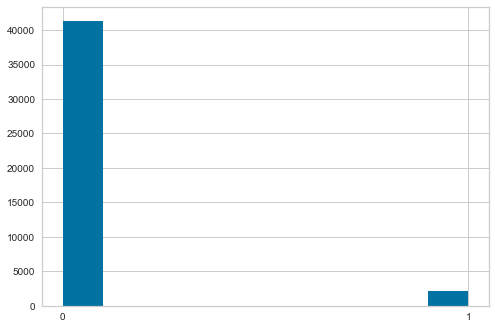

In [9]:
# Plot to better show the inbalanced target
plt.hist(df['class'])

In [10]:
# Convert the target in 0 an1

# classes = []

# for index, row in df.iterrows():
#     class_val = row['class']
#     if class_val not in classes:
#         classes.append(class_val)

# class_dict = {}

# for index, i in enumerate(classes):
#     class_dict.update({i:str(index)})
    
# df['class'] = df['class'].map(class_dict)

# All of the code above can be replaced with this
# Please note the use of 'b' infront of the string - so we are converting byte 0 to string 0.
df['class'] = df['class'].replace([b'0', b'1'], [0, 1])

df['class'].value_counts()

0    41314
1     2091
Name: class, dtype: int64

## EDA with Pandas Profile

In [ ]:
# It's not necessary to run this each time
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True)
profile.to_file(output_file="output.html")

The code above is used to generate a pandas profile report, which is very helpful in doing preliminary EDA rapidly. In it, you will find many columns which are skewed. We will use Robust Scaler later to address that issue.

Below we verify our final data frame.

In [11]:
# Verify 2 columns were removed
print(df.columns)

# Final dataframe
df.head()

Index(['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8',
       'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15',
       'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr22', 'Attr23',
       'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29', 'Attr30',
       'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36', 'Attr38',
       'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44', 'Attr45',
       'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50', 'Attr51', 'Attr52',
       'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57', 'Attr58', 'Attr59',
       'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64', 'class'],
      dtype='object')


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


# Model preparation

Which methods are you proposing to utilize to solve the problem?  Why is this method appropriate given the business objective? How will you determine if your approach is useful (or how will you differentiate which approach is more useful than another)?  More specifically, what evaluation metrics are most useful given that the problem is a binary-classification one (ex., Accuracy, F1-score, Precision, Recall, AUC, etc.)?

We will use a Random Forest and a Gradient Boosting model, along with grid search to find an optimal set values for the hyperparameters. For evaluation, we'll look at a combination of accuracy, precision, and recall.

If finding all bankruptcies is important, then recall would be the most important metric. But this comes at the expense of producing more false positives (accuracy), and therefore potentially investing more time trakcing account/clients that may never go bankrupt.

Below we prepare our dataset using train_test_split of 33%, imputing missing values with the mean, and then normalizing the data using RobustScaler.

In [12]:
# prepare test and train data

X = df.loc[:, df.columns != 'class'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [13]:
# Impute
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)

# Normalize the data
transformer = RobustScaler().fit(X_train)
transformer = RobustScaler().fit(X_test)
X_train = transformer.transform(X_train)
X_test= transformer.transform(X_test)

# Model building and Evaluation

In this case, your primary task is to build both a Random Forest and Gradient Boosting model to accurately predict bankruptcy and will involve the following steps:

- Specify your sampling methodology
- Setup your models - highlighting any important parameters
- Analyze each model's performance - referencing your chosen evaluation metric (including supplemental visuals and analysis where appropriate)

**Random Forest**
Below we setup a Random Forest model using RandomizedSearchCV to find optimal values for our hyperparameters. The following hyperparameters are considered:

*Max_depth:*
    - The maximum depth of the tree.
    - The default value is 3.
    - Higher values will result in a more complex tree structure.

*Max_features:*
    - The number of features to consider when looking for the best split.
    - The default value is the square root of the number of features.

*Min_samples_split:*
    - The minimum number of samples required to split an internal node.
    - The default value is 2.

*Bootstrap:*
    - Whether bootstrap samples are used when building trees.
    - The default value is True.

*Criterion:*
    - The function to measure the quality of a split.
    - The default value is "gini".


**Sampling Methodology:**
As mentioned earlier, we have a imbalanced dataset with only 5% of the data pertaining to bankruptcies. We will not use any oversampling or undersampling techniques for this case study. However, since we are using RandomizedSearchCV, it will by default use StratifiedKFold to keep the same ratio of the classes between the folds. We opted for RandomizedSearchCV for speed.

## Set up the Grid Search for Random Forest

In [14]:
# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# # use a full grid over all parameters
# param_grid = {"max_depth": [3, None],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [2, 3, 10],
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

# # run grid search
# grid_search = GridSearchCV(clf, param_grid=param_grid)
# start = time()
# grid_search.fit(X_train, y_train)

# print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#       % (time() - start, len(grid_search.cv_results_['params'])))
# report(grid_search.cv_results_)


RandomizedSearchCV took 192.84 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.968 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_split': 4}

Model with rank: 2
Mean validation score: 0.967 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_split': 6}

Model with rank: 3
Mean validation score: 0.965 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_split': 4}



## Evaluation of the Random Forest model

Below we output metrics related to the test set. We have a large accuracy of 97%, high precision of 85%, but a really poor recall of only 40%. We can see that we failed to identify 437 bankruptcies. The precision/recall curve helps to show that if we reduce our precision, we capture more bankruptcies (increase recall).

While the ROC curve at the end suggests that we are doing a good job, we really aren't if we are interested in capturing all bankruptcies.

In [15]:
y_hat_rf_test = random_search.predict(X_test)
accuracy_score(y_hat_rf_test, y_test)

0.9640463557665456

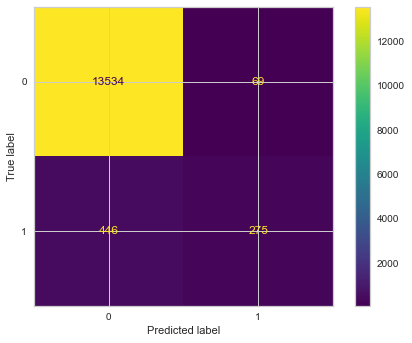

In [16]:
# Confusion matrix test
confusion_matrix(y_test, y_hat_rf_test)
disp = ConfusionMatrixDisplay.from_estimator(random_search, X_test, y_test)

In [17]:
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_rf_test, pos_label=1, average='binary'))
print("Precision:", precision_score(y_test, y_hat_rf_test, pos_label=1, average='binary'))

Recall: 0.3814147018030513
Precision: 0.7994186046511628


## Plot evaluation

C:\Users\dancr\miniconda3\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

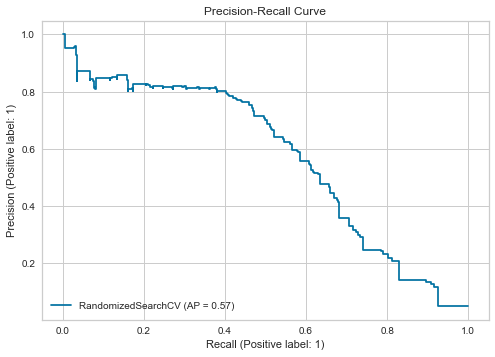

In [18]:
disp = plot_precision_recall_curve(random_search, X_test, y_test,)
disp.ax_.set_title('Precision-Recall Curve')

## ROC

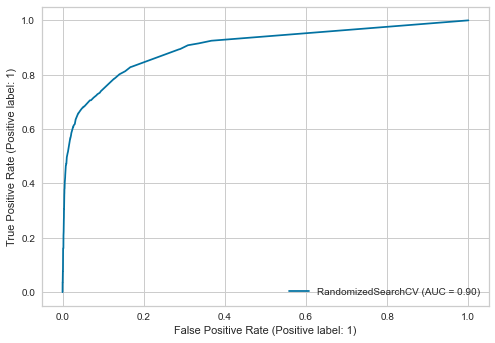

In [19]:
Disp = RocCurveDisplay.from_estimator(random_search, X_test, y_test)

### Deeper Dive into Random Forest Parameters

Let's dive a little deeper into our hyperparameters, and explore where our performance and test and train begins to diverge.


### `N_estimators`

- Number of estimators represent number of trees present in the model. 
- Typically, the higher the N_estimator is, the better the model learns the data. However we need to find a point at which it stops generalizing over the dataset. 
- The optimal number of estimators appears to be 5. 
- It appears that the tree does an excellent job predicting the training data, however, it fails to generalize over the test set. 

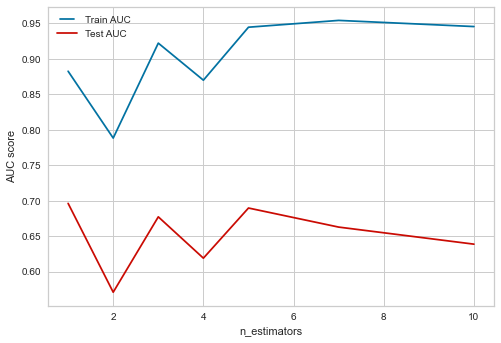

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

n_estimators = [1, 2, 3, 4, 5, 7, 10]
train_results = []
test_results = []

for estimator in n_estimators:
   model = RandomForestClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### `Max_depth`
- It appears that the models starts overfitting past max_depth of 7. 
- Optimal number of max_depth is 7

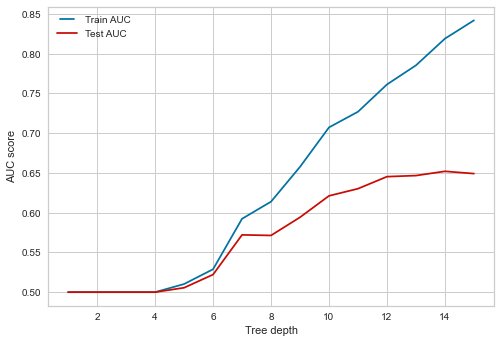

In [21]:
max_depths = np.linspace(1, 15, 15, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   model = RandomForestClassifier(max_depth=max_depth)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

### `Min_samples_splits`
- Min_samples_split is the minimum number of samples required to split an internal node. The higher this number is, the more the tree becomes constrained as it has to consider more samples at each node. 
- Here it is varied between 10% and 100%.

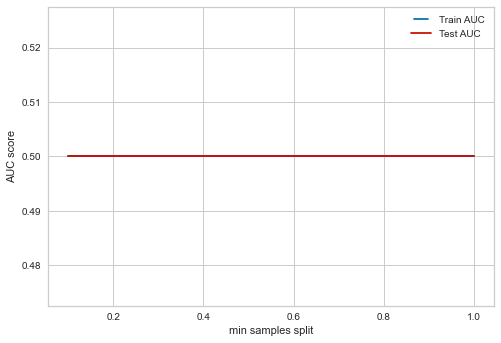

In [22]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
   model = RandomForestClassifier(min_samples_split=min_samples_split)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

### `Adjusting threshold for Random Forest model`
- Parameters for RF model are chosen based on the gridsearch result from above. 
- The best threshold for this RF model appears to be 0.2 from the Recall-Precision plot below. 
- Past this threshold, recall starts significantly dropping, whereas precision starts getting plateuaed. 
- Since we, as financial advisors, wish to predict more bankruptcies and sell more bankruptcy services to the corporates, we would like our model to have __high recall and low precision__. Thus we can set our threshold at 0.1 and 0.2 and see how our revenue model changes for each threshold. 

(0.0, 1.0)

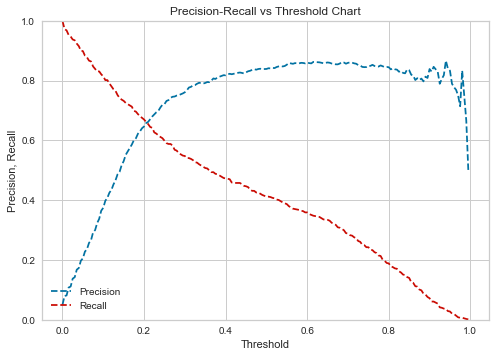

In [23]:
RF = RandomForestClassifier( bootstrap = False, criterion = 'entropy', max_depth = None, max_features = 10, min_samples_split = 3)
RF.fit(X_train, y_train)

from sklearn.metrics import precision_recall_curve
probs_y = RF.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

## Gradient Boosting Model

Let's take a similar approach with GBM to detemrine optimal hyperparameters.

Below we setup a GBM model using gridsearch to find optimal values for our hyperparameters. The following hyperparameters are considered:

### `Learning Rate`
- Learning rate shrinks the contribution of each tree to the model. 
- It appears that high learning rate results in overfitting. 
- Optimal learning rate is 0.5. 

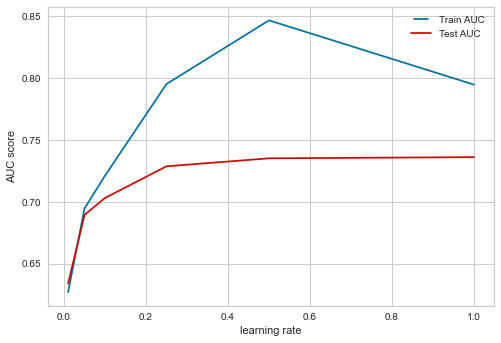

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []

for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("learning rate")
plt.show()

### `N_estimators`
- From the plot, it appears the optimal n_estimators is 100. 
- Past 100, it starts overfitting. 

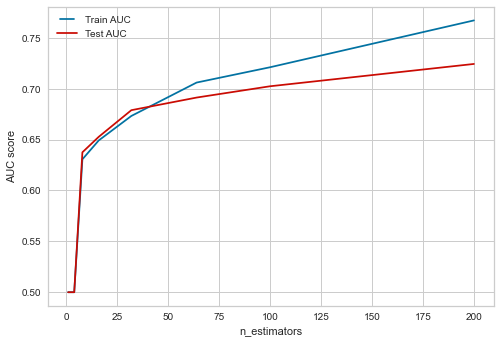

In [25]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### `Max_depth`
- It appears that the models starts overfitting past max_depth of 4. 
- Optimal number of max_depth is 4.

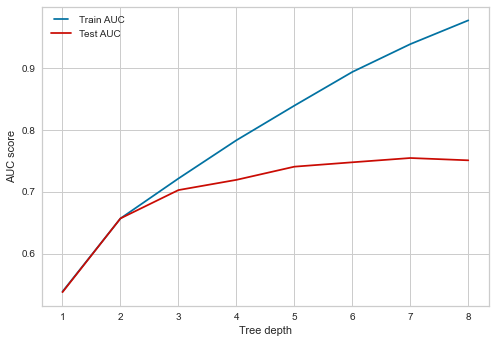

In [26]:
max_depths = np.linspace(1, 8, 8, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   model = GradientBoostingClassifier(max_depth=max_depth)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

### `Min_samples_splits`
- The result below shows that the model cannot learn enough of the data when all of its data are sampled at each node. 
- Higher min_samples_splits results in underfitting and thus the optimal value is 0.1. 

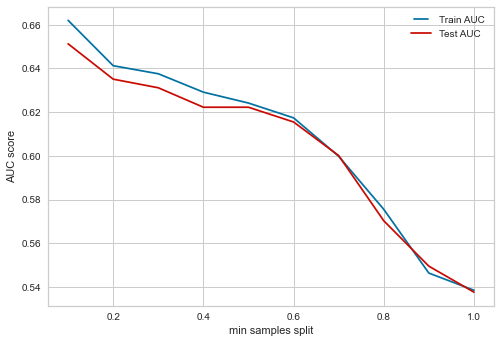

In [27]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
   model = GradientBoostingClassifier(min_samples_split=min_samples_split)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

### `Min_samples_leafs`
- The result below shows that the model cannot learn enough of the data when all of its data are sampled at each leaf node. 
- Higher Min_samples_leafs results in underfitting and thus the optimal value is 0.1. 

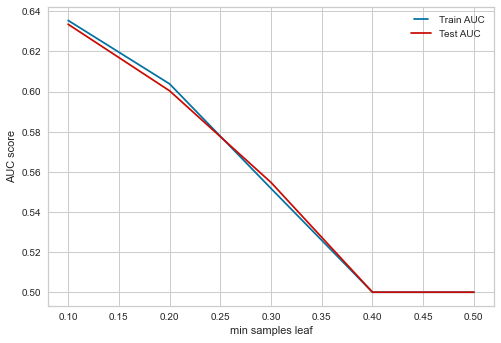

In [28]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
   model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples leaf")
plt.show()

### `Max features`
- Both the training and test set appears to be fit pretty well. 
- The AUC curve starts plateau around 30 number of features.

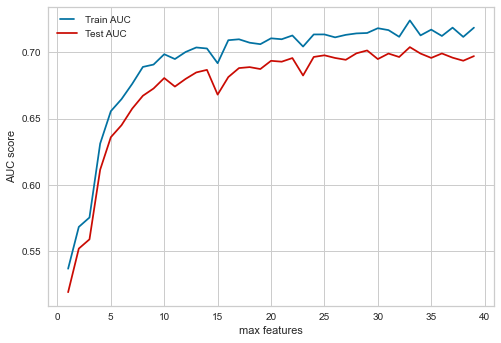

In [29]:
# max_features = list(range(1,X.shape[1]))
max_features = list(range(1,40))
train_results = []
test_results = []

for max_feature in max_features:
   model = GradientBoostingClassifier(max_features=max_feature)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, "b", label="Train AUC")
line2, = plt.plot(max_features, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max features")
plt.show()

### `Adjusting threshold for Grandient Boosting model`
- Parameters for GBM model are the optimal values chosen from the plots above instead of the gridsearch result since gridsearch took too much time to run for GBM. 
- The best threshold for this GBM model appears to be 0.2 from the Recall-Precision plot below. 
- Past this threshold, the rate at which recall start dropping is lower than the one with RF model. And the precision keeps increasing as the threshold goes up. 
- Overall, the Recall-Precision graph for GBM suggests that GBM is the better model than the RF model. Recall continously drops with RF, but in the plot below it levels off before dropping again.
- Like the RF model, we would like our model to have __high recall and low precision__. Thus we can set our threshold at 0.1 and 0.2 and see how our revenue model changes for each threshold.

(0.0, 1.0)

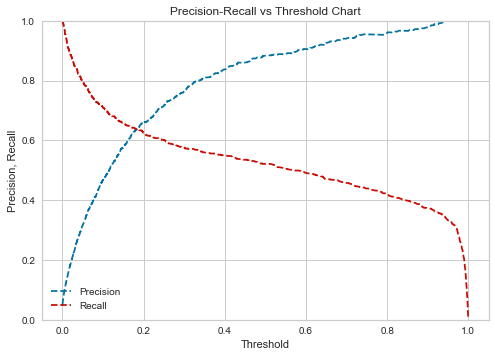

In [30]:
GBM = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.5, max_depth = 4, max_features = 30, min_samples_split = 0.01, min_samples_leaf = 0.01)
GBM.fit(X_train, y_train)

from sklearn.metrics import precision_recall_curve
probs_y = GBM.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

## GBM Model Evaluation

Below we output the same metrics we did for RF. In this case we see that our GBM model is slightly better. It has a comparable precision and accuracy, but with higher recall. To increase that further, we would use the threshold of 0.2 we found above.

In [48]:
# Accuracy, Precision and recall
y_hat_gbm = GBM.predict(X_test)

print("Accuracy:", accuracy_score(y_hat_gbm, y_test))
print("Recall:", recall_score(y_test, y_hat_gbm, pos_label=1, average='binary'))
print("Precision:", precision_score(y_test, y_hat_gbm, pos_label=1, average='binary'))

Accuracy: 0.9724937168388719
Recall: 0.521497919556172
Precision: 0.8847058823529412


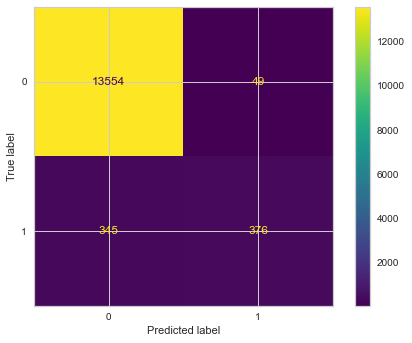

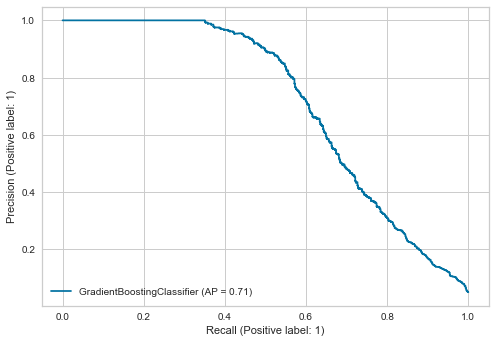

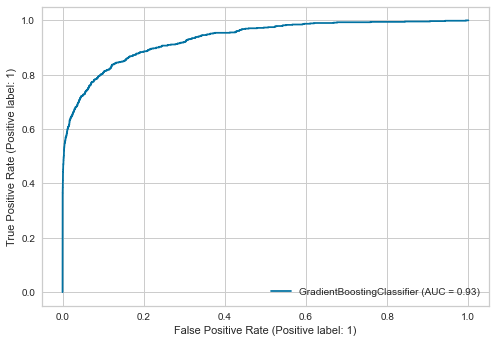

In [44]:
disp = ConfusionMatrixDisplay.from_estimator(GBM, X_test, y_test)
disp = PrecisionRecallDisplay.from_estimator(GBM, X_test, y_test)
disp = RocCurveDisplay.from_estimator(GBM, X_test, y_test)

# Model Interpretability & Explainability

Using at least one of your models above (if multiple were trained):

- Which variable(s) was (were) "most important" and why?  How did you come to the conclusion and how should your audience interpret this?

Below we use a library to output the 6 top features for our GBM model.

* Attr. 34 = operating expenses / total liabilities
* Attr. 27 = profit on operating activities / financial expenses
* Attr.  9 = sales / total assets
* Attr. 46 = (current assets - inventory) / short-term liabilities
* Attr.  5 = [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
* Attr.  6 = retained earnings / total assets

Based on the above, we can see that Operating Expenses has a strong impact on bankruptcies, which makes sense. However, can't infer if it will steer the prediction one way or the other.

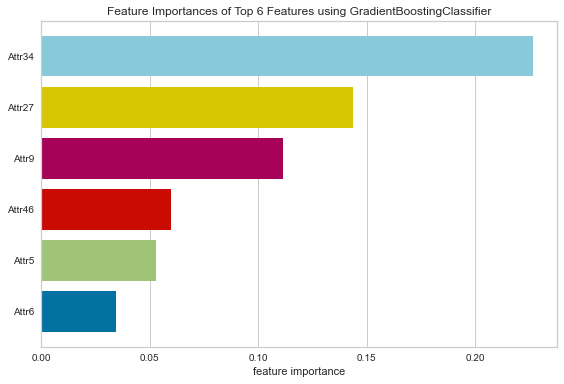

<AxesSubplot:title={'center':'Feature Importances of Top 6 Features using GradientBoostingClassifier'}, xlabel='feature importance'>

In [47]:
viz = FeatureImportances(GBM, topn=6, relative=False, labels=df.columns.to_list())
viz.fit(X_test, y_test)
viz.show()

# Conclusion

RF and GBM had comparable precision and accuracy, but GBM model performed slightly better in terms of recall. The higher Recall-Precision distribution across different thresholds also suggest that GBM is the better model. Features such as Attr. 34 (operating expenses / total liabilities) and Attr. 27(profit on operating activities / financial expenses) are two most important factors for determining bankruptcies. Further research is needed determine if these top features contribute to bankruptcies or not. Additionally, we could explore different sampling techniques to balance the dataset along with other ensemble methods.